### FROM SAV TO LOVE

# HW №7 Video

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH        
Библиотеки: [Python, Tensorflow]  

### Подключение библиотек и скриптов

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For Google Colaboratory
%tensorflow_version 2.x

In [ ]:
import os
import glob
import random

import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
if 0:
    !pip install scikit-video==1.1.11
import skvideo.io

In [ ]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Загрузка данных

In [ ]:
if 0:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

### Подготовка датасета для классификации

In [ ]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


### Визуализация кадра

videodata shape: (432, 120, 160, 3)


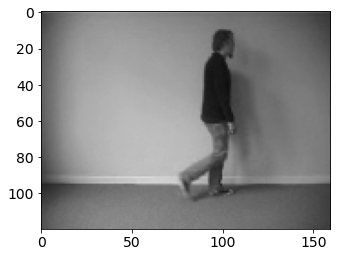

In [ ]:
videodata = skvideo.io.vread(dataset[47][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[49, ...])

### Визуализация «движения»

motion shape: (431, 120, 160, 1)


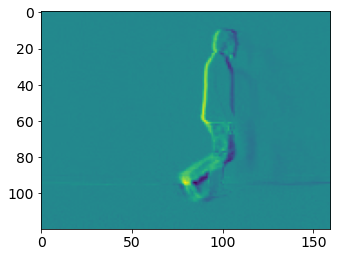

In [ ]:
motion = np.mean(videodata[1:] - videodata[:-1], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[49, ..., 0])

### Создание модели CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(16, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),

    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),

    tf.keras.layers.Conv3D(32, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),

    tf.keras.layers.Conv3D(32, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

### Подготовка к обучению

In [ ]:
random.shuffle(dataset)

split = int(len(dataset) * 0.8)
train, test = dataset[:split], dataset[split:]

print('Dataset samples (subset):', len(train), len(test))

Dataset samples (subset): 479 120


In [ ]:
def prep_to_model(fpath, label):
    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.

    motion = np.mean(videodata[1:] - videodata[:-1], axis=3, keepdims=True)

    x = motion[None, ...]
    y = np.array(label)[None, ...]
    
    return x, y

In [ ]:
NUM_EPOCHS = 4
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)) # RMSprop / Adamax
    
writer = tf.summary.create_file_writer('logs/exp1')

### Обучение модели

In [ ]:
%%time

train_loss = []

for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(train):
        x, y = prep_to_model(fpath, label)

        loss_value = model.train_on_batch(x, y)
        train_loss.append(loss_value)

        if iter % 50 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(train)}] Loss = {loss_value}')

[0/4][0/479] Loss = 1.7956575155258179
[0/4][50/479] Loss = 1.761582374572754
[0/4][100/479] Loss = 1.7345972061157227
[0/4][150/479] Loss = 1.0469894409179688
[0/4][200/479] Loss = 1.3198060989379883
[0/4][250/479] Loss = 1.2823805809020996
[0/4][300/479] Loss = 0.8171898126602173
[0/4][350/479] Loss = 1.3338005542755127
[0/4][400/479] Loss = 1.6630500555038452
[0/4][450/479] Loss = 2.145176410675049
[1/4][0/479] Loss = 0.8590563535690308
[1/4][50/479] Loss = 0.39614519476890564
[1/4][100/479] Loss = 0.6411611437797546
[1/4][150/479] Loss = 0.5178368091583252
[1/4][200/479] Loss = 0.919568657875061
[1/4][250/479] Loss = 1.1573359966278076
[1/4][300/479] Loss = 0.00242380378767848
[1/4][350/479] Loss = 0.5303161144256592
[1/4][400/479] Loss = 1.6752333641052246
[1/4][450/479] Loss = 0.7335177063941956
[2/4][0/479] Loss = 0.03533608838915825
[2/4][50/479] Loss = 0.05960153415799141
[2/4][100/479] Loss = 0.24787859618663788
[2/4][150/479] Loss = 0.058213971555233
[2/4][200/479] Loss = 0.

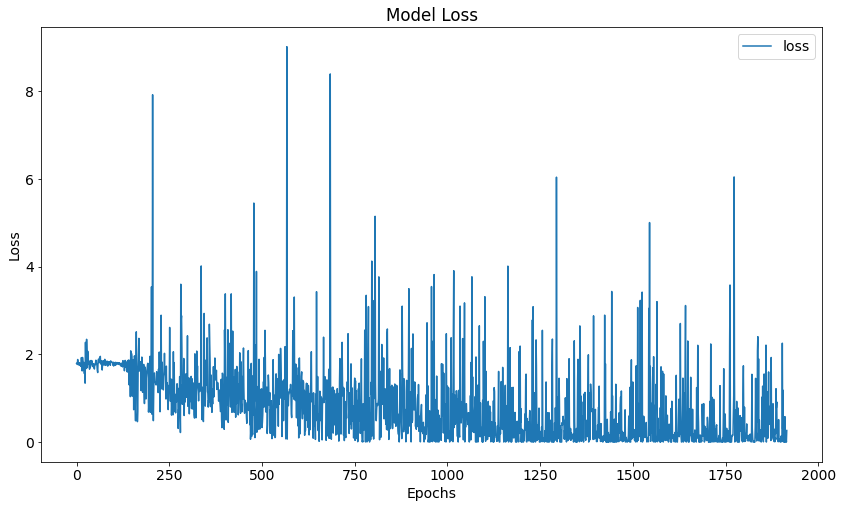

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(train_loss, label='loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

### TensorBoard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs

### Тестирование обученной модели

True class: handclapping
Predicted class: handclapping
Probability: 3.96


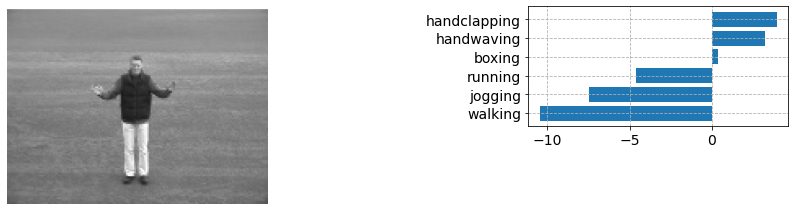

True class: handclapping
Predicted class: handclapping
Probability: 4.90


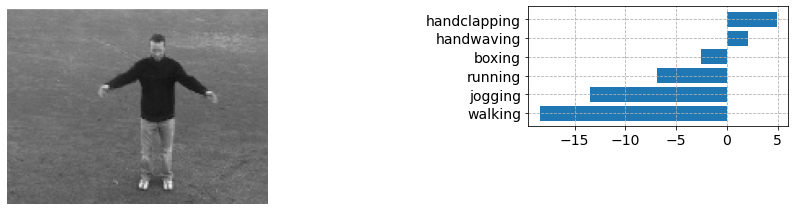

True class: boxing
Predicted class: boxing
Probability: 5.92


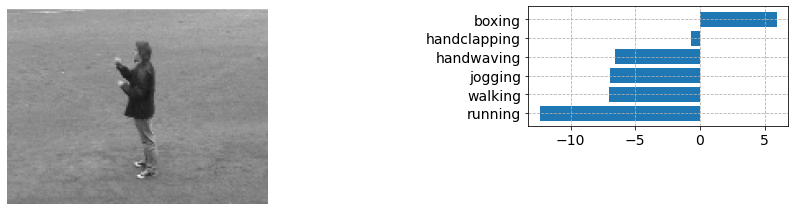

True class: handclapping
Predicted class: handclapping
Probability: 4.54


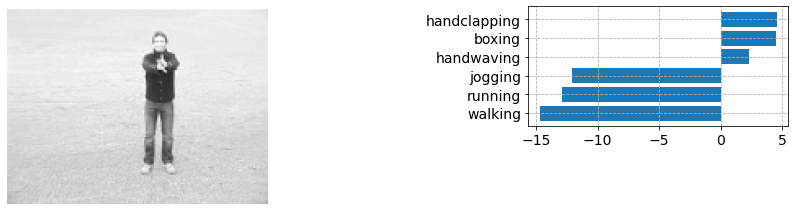

True class: handclapping
Predicted class: handclapping
Probability: 3.81


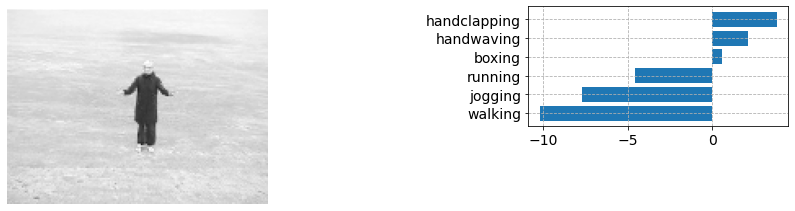

In [ ]:
for i in range(5):
    fpath, cls_true = random.choice(test)
    motion = prep_to_model(fpath, cls_true)[0]

    out = model(motion)
    prob = out[0].numpy()
    pred_perc = np.max(prob)
    cls_pred = np.argmax(prob)

    print(f'True class: {classes[cls_true]}\n',
          f'Predicted class: {classes[cls_pred]}\n',
          f'Probability: {pred_perc:.2f}', sep ='')

    # image
    plt.figure(figsize=(14, 11))
    plt.subplot(3, 2, 1)
    videodata = skvideo.io.vread(fpath)
    plt.imshow(videodata[30, ...])
    plt.axis('off')

    # accuracy
    plt.subplot(5, 2, 2)
    motion_prob = sorted(zip(classes, prob), key=lambda mp: mp[1])
    m = np.array(motion_prob)[:, 0]
    p = np.array(motion_prob)[:, 1].astype(np.float32)
    
    bars = plt.barh(m, p)

    plt.subplots_adjust(wspace=1, hspace=0)

    plt.grid(True, linestyle='--')

    plt.show()